In [3]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision
%matplotlib inline

In [5]:
# Hyperparameters
batch_size = 64
epochs = 10
learning_rate = 0.001

# Transformation to downscale images to 14x14 and normalize
transform = transforms.Compose([
    transforms.Resize((14, 14)),  # Downscale image to 14x14
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear = nn.Linear(8 * 3 * 3, 10)
    
    
    def forward(self, x):
        # Apply first convolutional layer + ReLU activation
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {count_parameters(model)}")

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Print statistics every 100 batches
        if i % 100 == 99:
            print(f"Epoch {epoch+1}/{epochs}, Iteration {i+1}/{len(train_loader)}, Loss: {running_loss / 100:.4f}")
            running_loss = 0.0
    
    # Print statistics for each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Total number of parameters in the model: 1066
Epoch 1/10, Iteration 100/938, Loss: 2.2368
Epoch 1/10, Iteration 200/938, Loss: 1.6104
Epoch 1/10, Iteration 300/938, Loss: 0.8099
Epoch 1/10, Iteration 400/938, Loss: 0.5598
Epoch 1/10, Iteration 500/938, Loss: 0.4581
Epoch 1/10, Iteration 600/938, Loss: 0.4038
Epoch 1/10, Iteration 700/938, Loss: 0.3456
Epoch 1/10, Iteration 800/938, Loss: 0.3407
Epoch 1/10, Iteration 900/938, Loss: 0.3011
Epoch 1/10, Loss: 0.0117, Accuracy: 78.14%
Epoch 2/10, Iteration 100/938, Loss: 0.2752
Epoch 2/10, Iteration 200/938, Loss: 0.2545
Epoch 2/10, Iteration 300/938, Loss: 0.2590
Epoch 2/10, Iteration 400/938, Loss: 0.2406
Epoch 2/10, Iteration 500/938, Loss: 0.2259
Epoch 2/10, Iteration 600/938, Loss: 0.2231
Epoch 2/10, Iteration 700/938, Loss: 0.2318
Epoch 2/10, Iteration 800/938, Loss: 0.2098
Epoch 2/10, Iteration 900/938, Loss: 0.1936
Epoch 2/10, Loss: 0.0082, Accuracy: 93.18%
Epoch 3/10, Iteration 100/938, Loss: 0.1799
Epoch 3/10, Iteration 200/938, L

In [6]:
# Find test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test accuracy: {correct / total}')

Test accuracy: 0.9692


In [18]:
# Randomly sample 100 images from the train set for hessian estimation
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
x_samples = []
y_samples = []
for inputs, labels in train_loader:
    x_samples.append(inputs)
    y_samples.append(labels)
    break
x_samples = torch.cat(x_samples)
y_samples = torch.cat(y_samples)
loader = DataLoader(TensorDataset(x_samples, y_samples), batch_size=1)

In [23]:
hess = compute_hessian(model, criterion, x_samples, y_samples)
pred_hess = hessian(model, criterion, dataloader=loader, cuda=False)

print("Computed Hessian matrix")
vals, vecs = np.linalg.eigh(hess)
vecs = vecs.T
print("Computed eigenvalues and eigenvectors")

Computed Hessian matrix
Computed eigenvalues and eigenvectors


d:\miniconda3\envs\deephessian\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


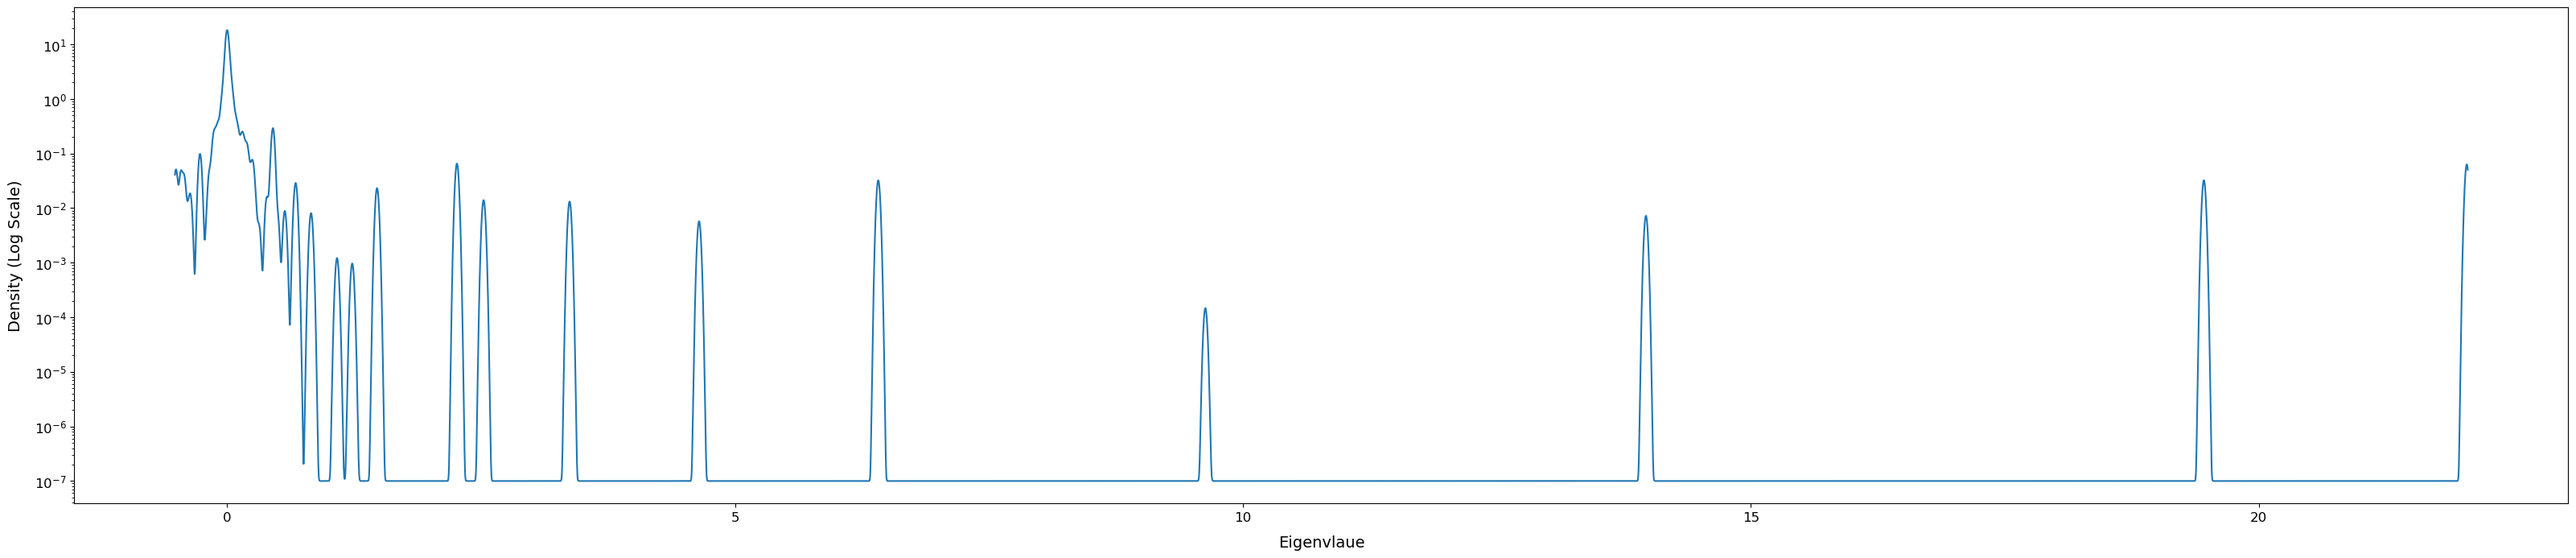

In [22]:
get_esd_plot(*pred_hess.density())

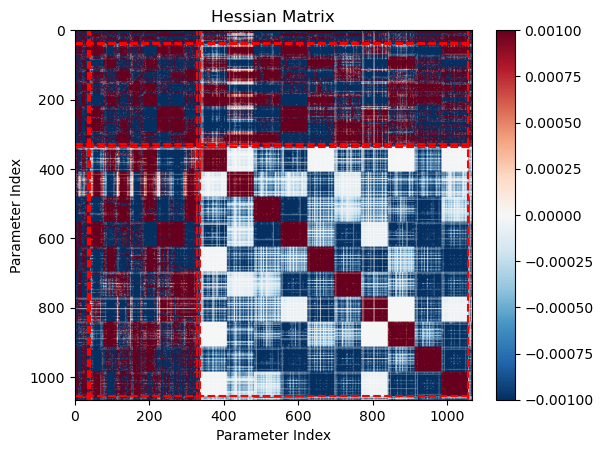

In [16]:
# Display the hessian 
plot_hessian(model, criterion, x_samples, y_samples)

In [27]:
true_couple = list(zip(vals, vecs))
# Sort the couple based on absolute value of the eigenvalues
true_couple.sort(key=lambda x: abs(x[0]))
true_couple.reverse()

In [45]:
def get_reconstruction_loss(matrix):
    vals, vecs = np.linalg.eigh(matrix)
    vecs = vecs.T
    couple = list(zip(vals, vecs))
    couple.sort(key=lambda x: abs(x[0]))
    couple.reverse()
    current_matrix = np.zeros(matrix.shape)
    errors = []
    for i in range(len(couple)):
        val, vec = couple[i]
        reconstructed_matrix = val * np.outer(vec, vec)
        current_matrix += reconstructed_matrix
        error = np.linalg.norm(current_matrix - matrix) / np.linalg.norm(matrix)
        errors.append(error)
    return errors

def plot_reconstruction_loss(errors, epsilon=None, acc = None, title="Reconstruction Loss", save_path = None):
    plt.plot(errors)
    plt.xlabel("Number of Eigenvalues")
    plt.ylabel("Relative Error")
    plt.title(title)
    if epsilon is not None:
        num_required = np.argmax(np.array(errors) < epsilon)
        plt.axvline(x=num_required, color='r', linestyle='--', label=f"Number of Eigenvalues: {num_required} for epsilon={epsilon}")
        # Horizontal line for epsilon
        plt.axhline(y=epsilon, color='g', linestyle='--', label=f"Epsilon: {epsilon}")
        plt.legend()
    # Add a box on the right showing the test accuracy of the model (given by acc)
    if acc is not None:
        plt.text(0.7, 0.7, f"Test Accuracy: {100*acc:.2f}%", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.5))

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def accuracy(model, test_data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_data:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

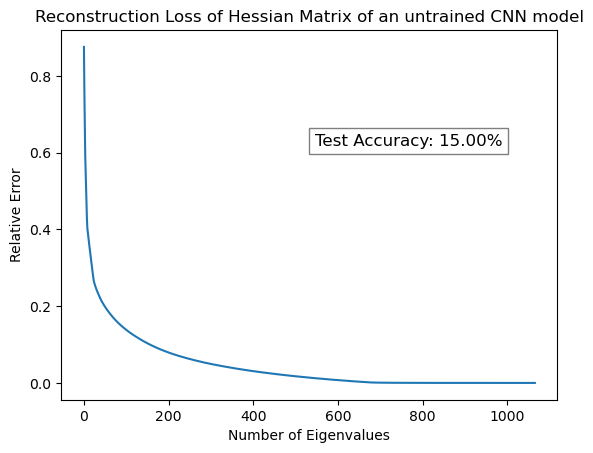

In [44]:
# Using a random matrix to test the function
# random_matrix = np.random.rand(692, 692)
# random_matrix = random_matrix @ random_matrix.T
model_init = SimpleCNN()
hess_init = np.array(compute_hessian(model_init, criterion, x_samples, y_samples))
errors = get_reconstruction_loss(hess_init)
plot_reconstruction_loss(errors, acc = accuracy(model_init, loader),  title="Reconstruction Loss of Hessian Matrix of an untrained CNN model")

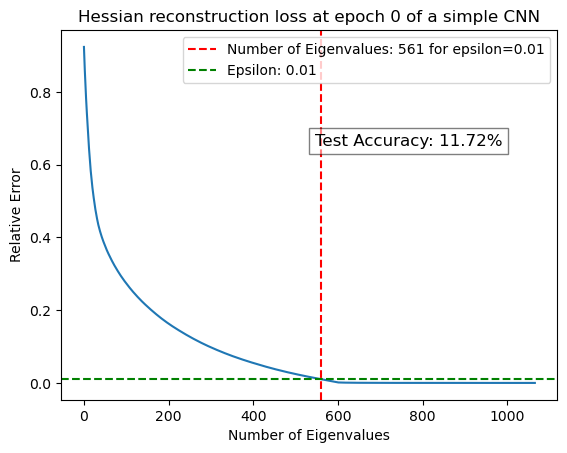

Epoch 1/10, Loss: 0.3534409999847412


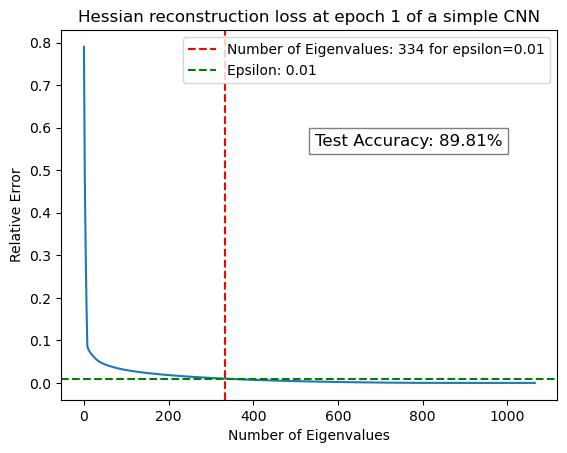

Epoch 2/10, Loss: 0.2297326922416687


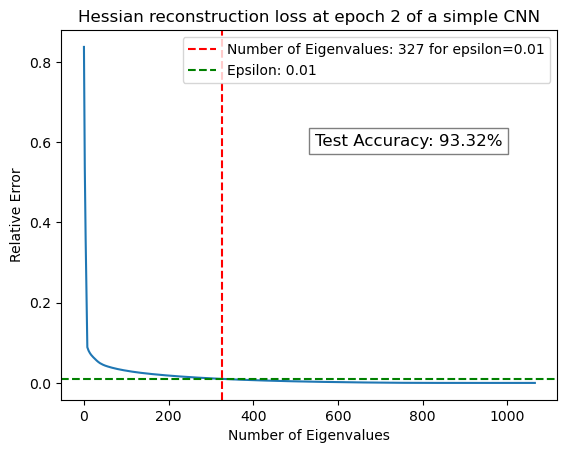

Epoch 3/10, Loss: 0.15527042746543884


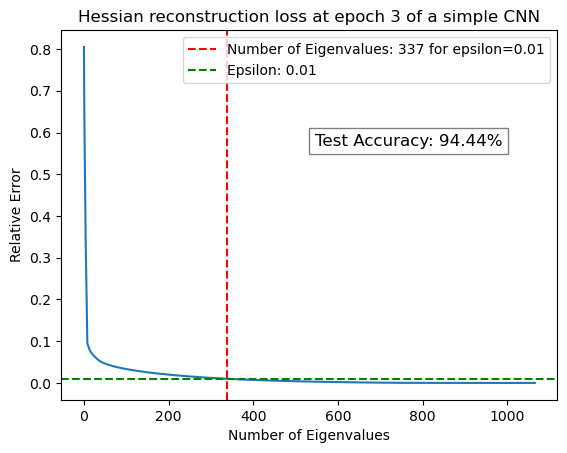

Epoch 4/10, Loss: 0.13253240287303925


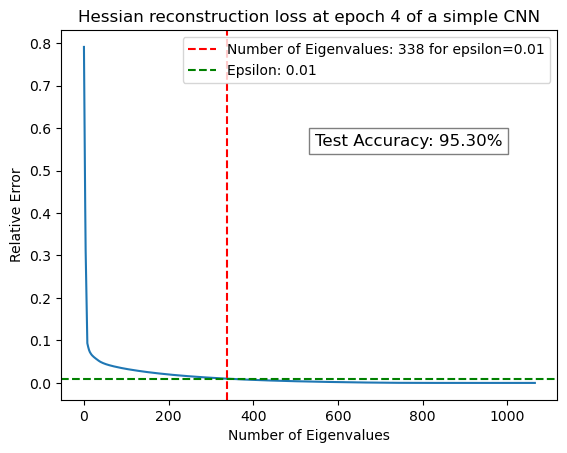

Epoch 5/10, Loss: 0.08438082784414291


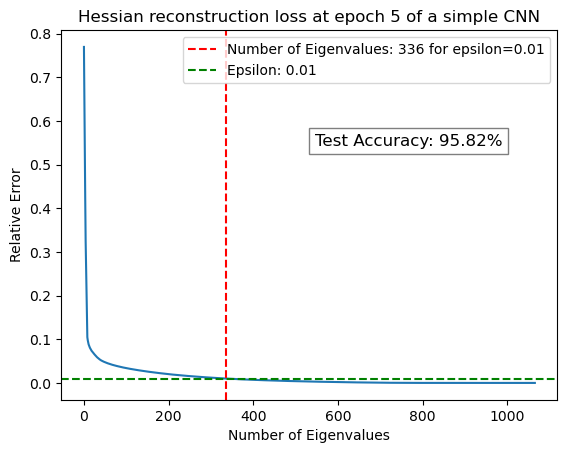

Epoch 6/10, Loss: 0.14078690111637115


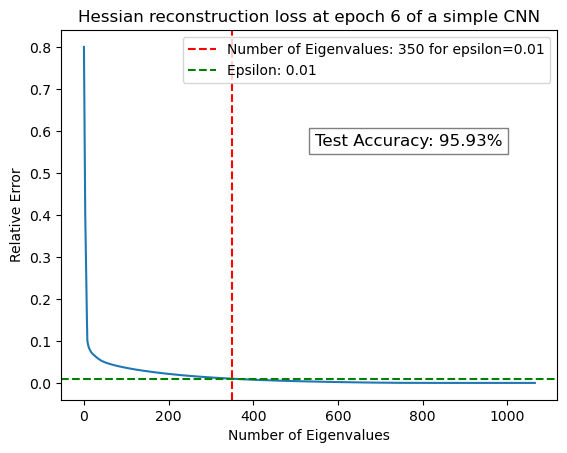

Epoch 7/10, Loss: 0.13354043662548065


KeyboardInterrupt: 

In [ ]:
# Finding hessian matrix per epoch and plotting the error in reconstruction
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epsilon = 5e-3
num_req_arr = []
num_epochs = 10
for epoch in range(num_epochs):
    hessian_matrix = np.array(compute_hessian(model, criterion, x_samples, y_samples))
    errors = get_reconstruction_loss(hessian_matrix)
    num_required = np.argmax(np.array(errors) < epsilon)
    num_req_arr.append(num_required)
    acc = accuracy(model, test_loader)
    model.train()
    plot_reconstruction_loss(errors, epsilon=epsilon, acc = acc, title=f"Hessian reconstruction loss at epoch {epoch} of a simple CNN", save_path=f"hessian_reconstruction_cnn/epoch_{epoch}.png")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

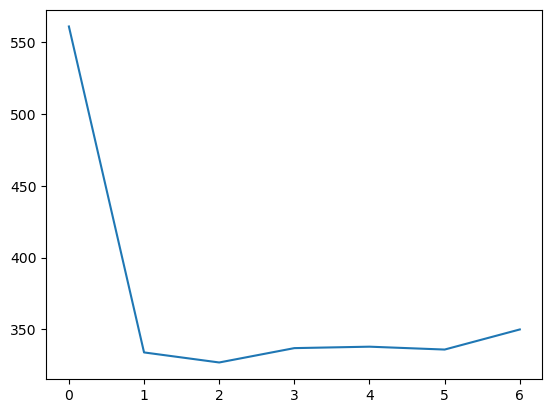

In [47]:
plt.plot(num_req_arr)